In [2]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, plot_coverage, print_forecasts_by_week, forecast_by_week, train_test_split, update_deepAR_parameters
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset,StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import ray
from ray.air import session
from ray import tune
from gluonts.mx.distribution import NegativeBinomialOutput
config = Configuration()
hyperpar_df =  pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Hyperparameter_results.csv", sep=',')

In [16]:
cols = ["mean_WIS", "time_total_s"] + [col for col in hyperpar_df.columns if ("config" in col)&("cardinality" not in col)&("use_feat_static_cat" not in col)]
display(hyperpar_df.sort_values("mean_WIS")[cols].head(20))

,mean_WIS,time_total_s,config/cell_type,config/context_length,config/epochs,config/num_cells,config/num_layers,config/use_feat_dynamic_real,config/use_feat_static_real
138,405.131517,2959.219544,lstm,4,20,20,3,True,False
193,425.023019,2954.020114,gru,4,20,20,4,True,False
204,438.612487,2322.177556,lstm,4,8,40,4,True,False
156,441.219969,3277.330664,lstm,4,20,40,3,True,False
157,463.845212,3134.160345,gru,4,20,40,3,True,False
97,467.625083,2028.248731,gru,4,8,40,4,False,False
151,469.011588,1997.891276,gru,4,8,40,3,True,False
13,472.714842,2527.833745,gru,4,20,10,3,False,False
121,473.873123,2741.495118,gru,4,20,10,3,True,False
210,477.865911,3576.734818,lstm,4,20,40,4,True,False


In [19]:
print(len(hyperpar_df))

432


In [3]:
def hyperparameter_boxplots(results_df, hp_search_space, col="mean_WIS"):
    """
    Plot the hyperparameters as boxplots.
    """
    # Create a dict of filtered dfs and x_tick- renamings
    hp_plots = dict()
    for key in hp_search_space.keys():
        if type(hp_search_space[key]) == type(dict()):
            search_grid = hp_search_space[key][list(hp_search_space[key].keys())[0]]
            hp_plots[key] = {"cols" : [f"{i} {key}" for i in search_grid], "df": [results_df.loc[results_df[f'config/{key}']==i][col] for i in search_grid]}
    
    # plot the boxplots
    nrows = int(len(hp_plots.keys())/2) + (int(len(hp_plots.keys())/2)%2)
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 9), sharey=True)
    fig.tight_layout(pad=1.2)
    plotnumber = [0, 0]
    for key in hp_plots.keys():
        if list(hp_plots.keys()).index(key)%2 == 1:
            plotnumber[1] = 1
        else:
            if list(hp_plots.keys()).index(key) > 1:
                plotnumber[0] += 1
            plotnumber[1] = 0
        axs[tuple(plotnumber)].boxplot(hp_plots[key]["df"])
        axs[tuple(plotnumber)].set_title(key)
        axs[tuple(plotnumber)].set_xticks([i for i in range(1, len(hp_plots[key]["df"])+1)], hp_plots[key]["cols"])
        axs[tuple(plotnumber)].set_ylabel(col)
    plt.show()

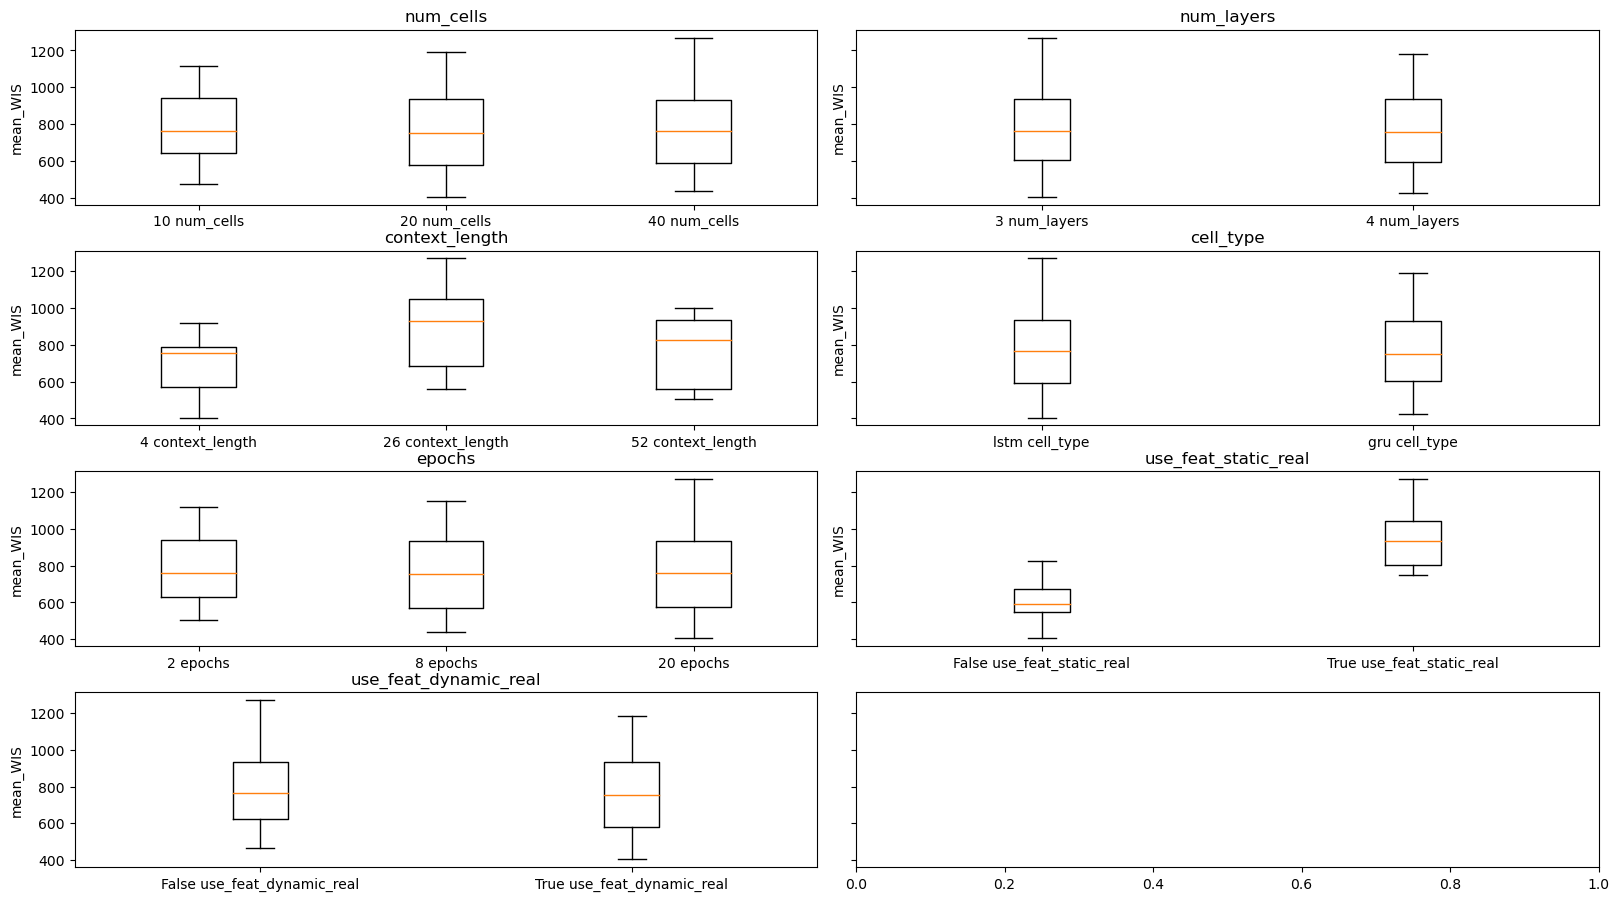

________________


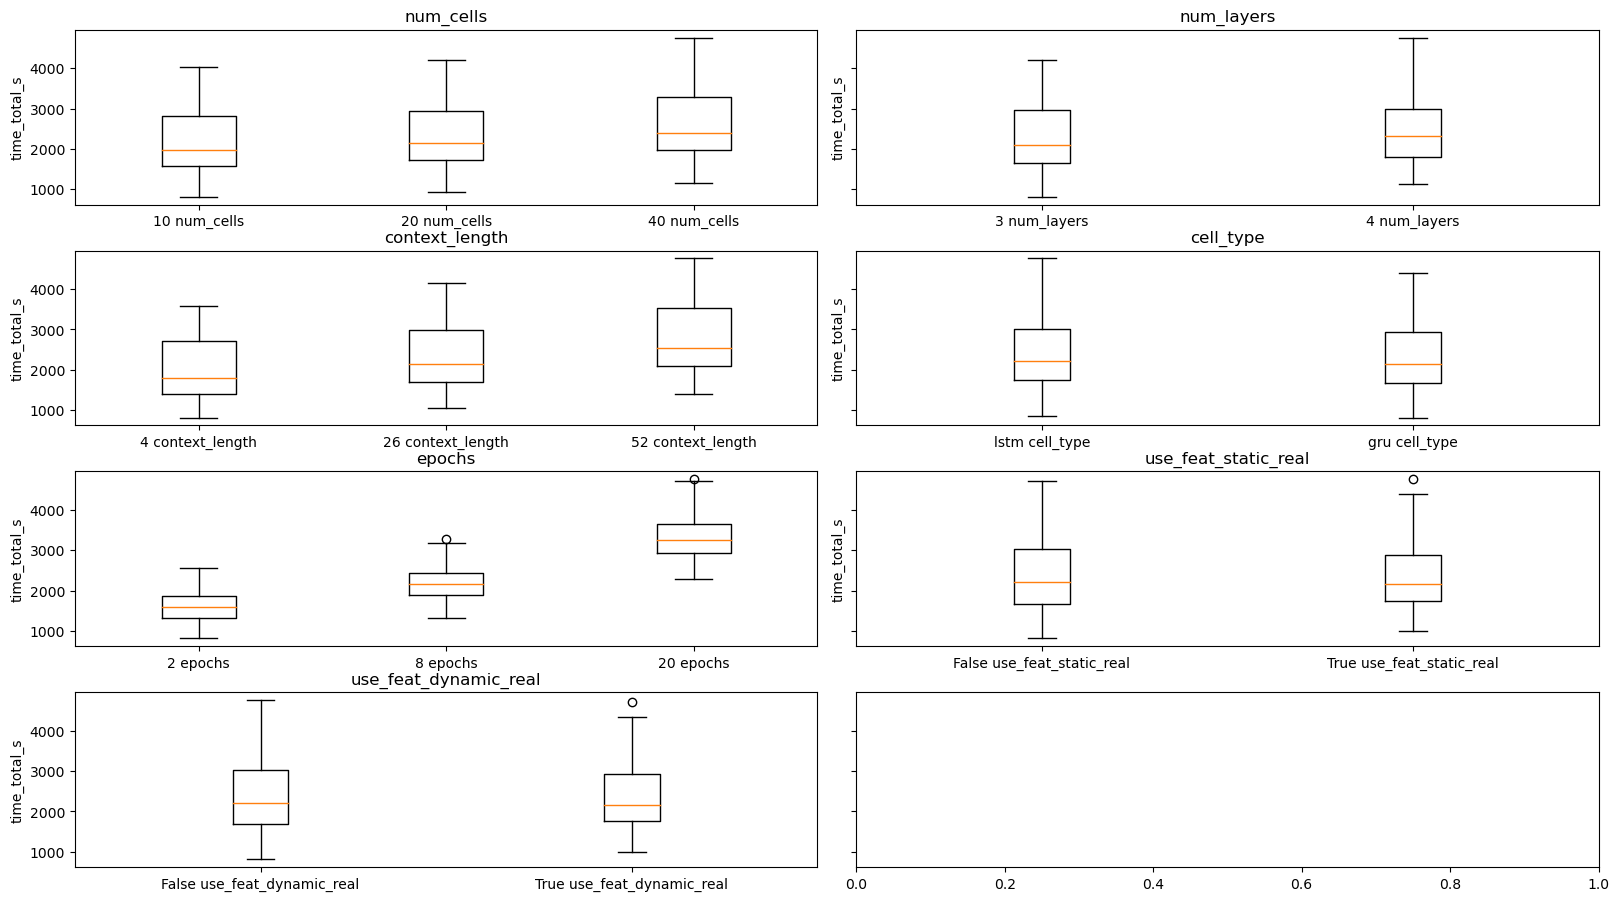

In [5]:
hp_search_space = {
    "num_cells": tune.grid_search([10, 20, 40]),
    "num_layers": tune.grid_search([3, 4]),
    "context_length":tune.grid_search([4, 104, 208]),
    "cell_type":tune.grid_search(["lstm", "gru"]),
    "epochs":tune.grid_search([2, 8, 20]),
    "use_feat_static_real":tune.grid_search([False,True]),
    "use_feat_dynamic_real":tune.grid_search([False,True]),
    "use_feat_static_cat":True,
    "cardinality":[2]*411,
}
hyperparameter_boxplots(hyperpar_df, hp_search_space, col="mean_WIS")
print("________________")
hyperparameter_boxplots(hyperpar_df, hp_search_space, col="time_total_s")